In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import matplotlib.cm as cm
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS,DBSCAN
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
import sklearn

In [217]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Présentation

Dans ce notebook, on essaye d'identifier les brain states de la condition awake grâce à la méthode CEBRA.

## Fonctions utiles

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    #optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

In [3]:
def generate_vector_distance_inter_zones(X,Y):
    a,b = X.shape
    c,d = Y.shape
    distance = np.zeros((a,c))
    for i in range(a):
        for j in range(c):
            distance[i,j] = np.linalg.norm(X[i,:] - Y[j,:])
    return distance

In [4]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i],cmap="hot")
        plt.axis('off')
        plt.title(li_titles[i])

In [5]:
cd /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs

/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs


In [6]:
ls

input_flat.npy*  labels.tsv*  metadata.tsv*     structural.txt*
inputs.npy*      labels.txt*  regionalmap.pdf*


## Data Loading

Dans le train, on garde les singes 'almira', 'khali', 'kimiko', 'rana'.
Dans le test, on utilise 'jade'.

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [4]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [17]:
meta["condition"][:31*464]

0        awake
1        awake
2        awake
3        awake
4        awake
         ...  
14379    awake
14380    awake
14381    awake
14382    awake
14383    awake
Name: condition, Length: 14384, dtype: object

In [20]:
dfc_all.shape

(156, 464, 82, 82)

## Animation

Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie0.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie1.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie2.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie3.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie4.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie5.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie6.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie7.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie8.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie9.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie10.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/

/tmp/ipykernel_24759/1493363126.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie20.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie21.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie22.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie23.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie24.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie25.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie26.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie27.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie28.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie29.mp4
Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie30.mp4


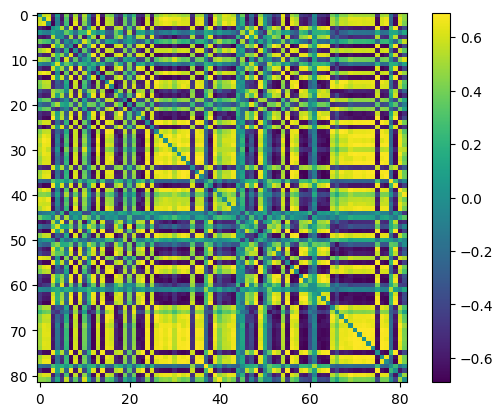

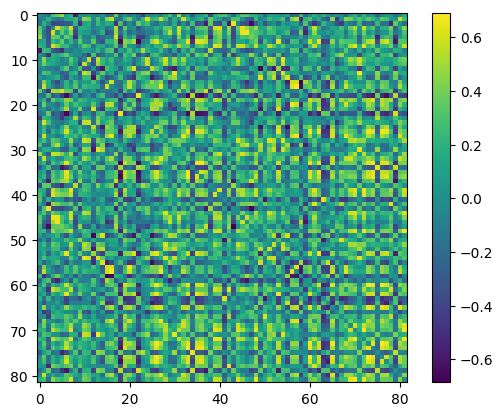

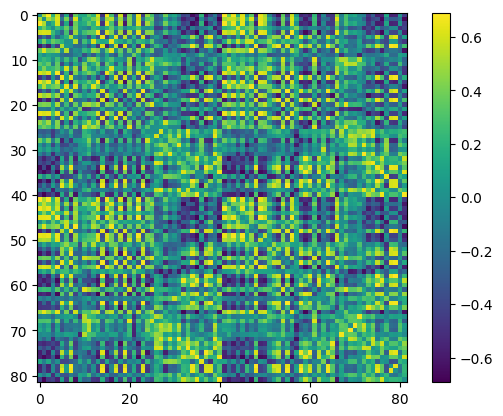

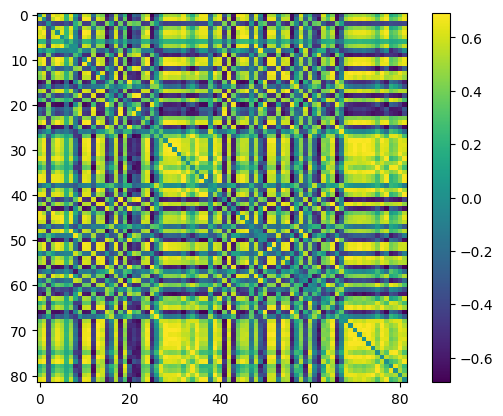

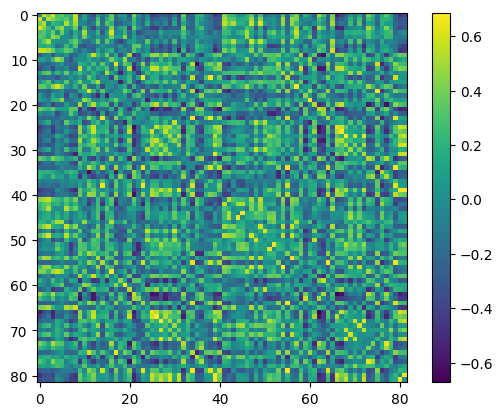

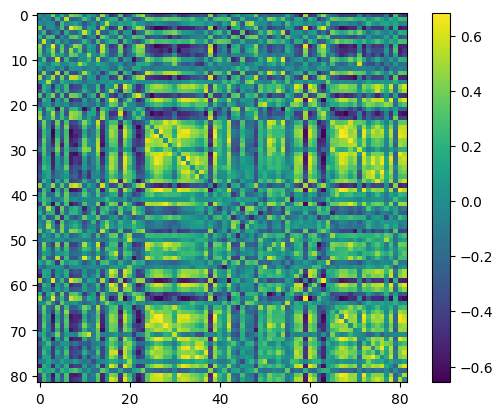

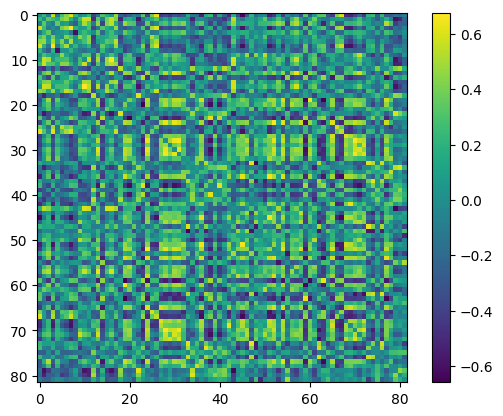

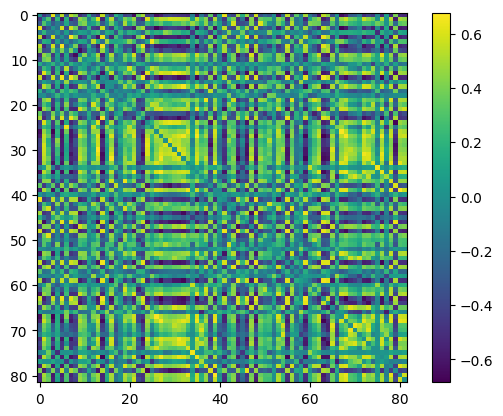

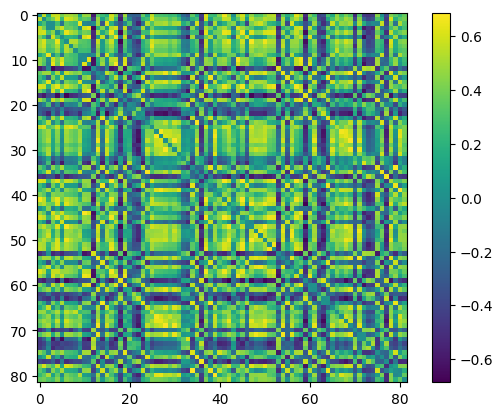

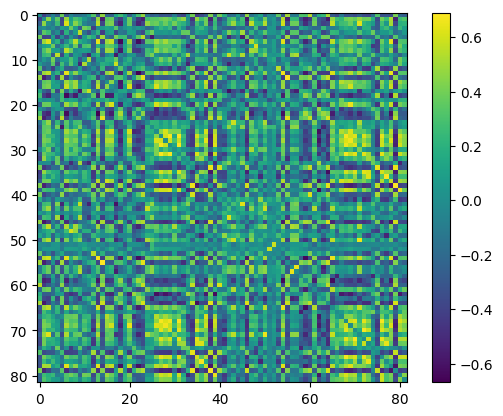

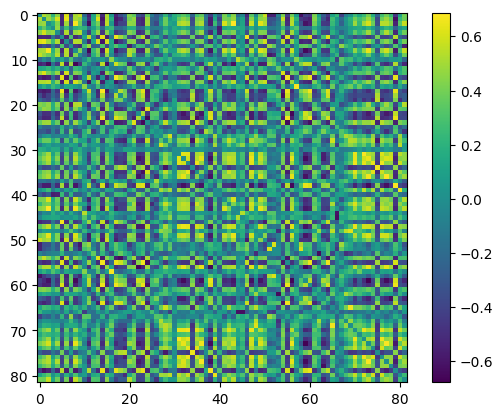

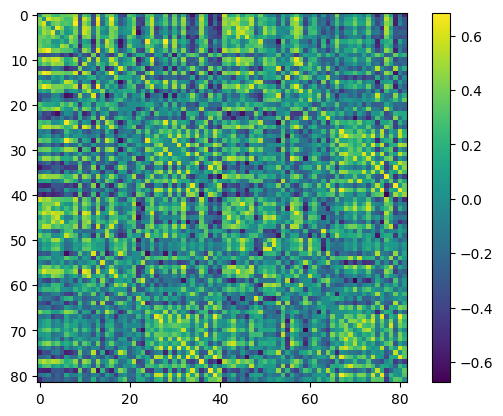

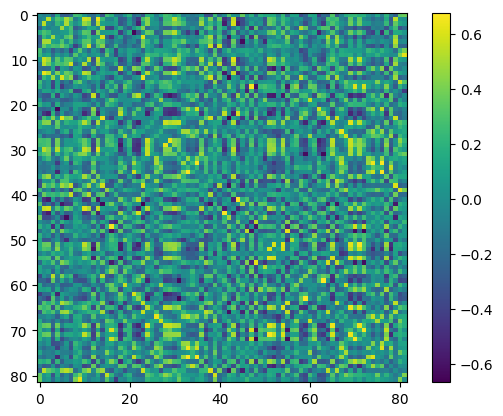

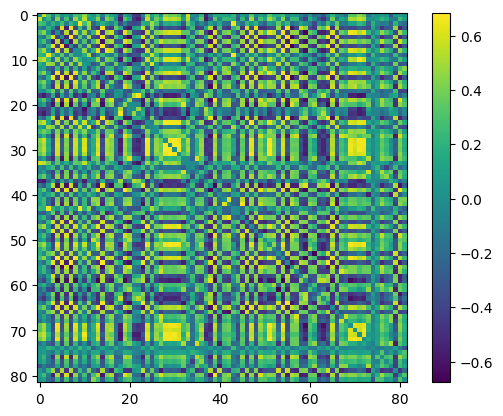

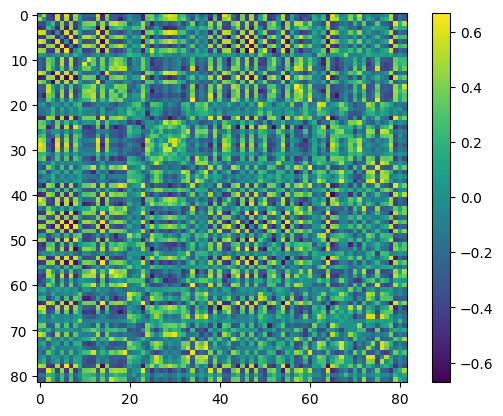

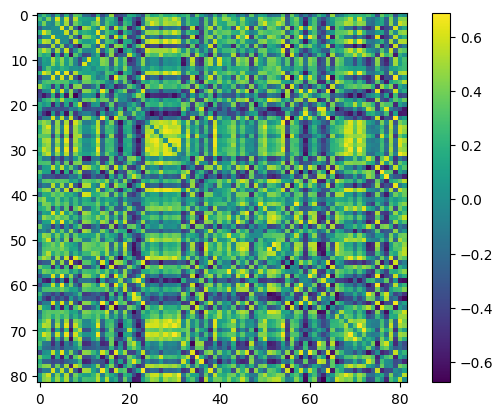

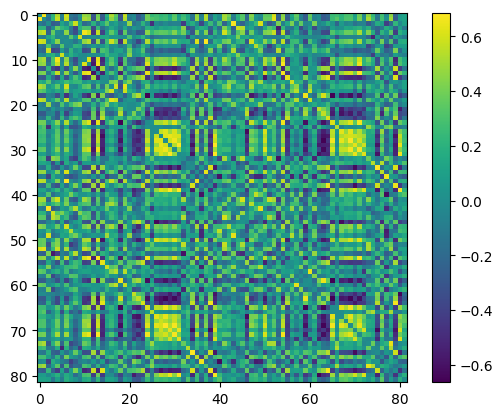

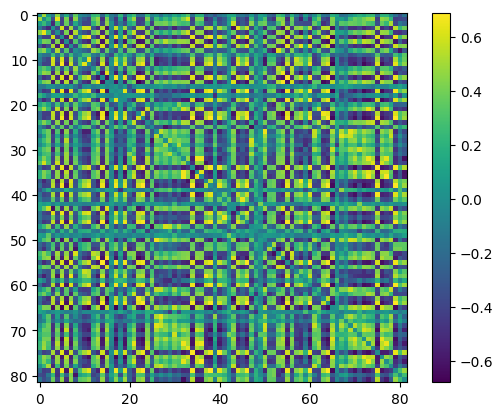

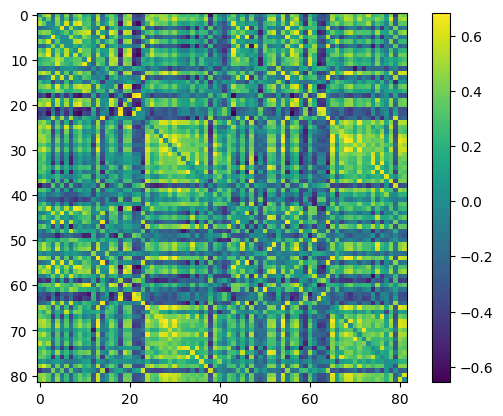

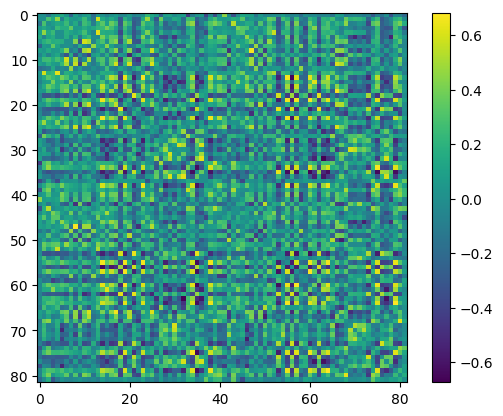

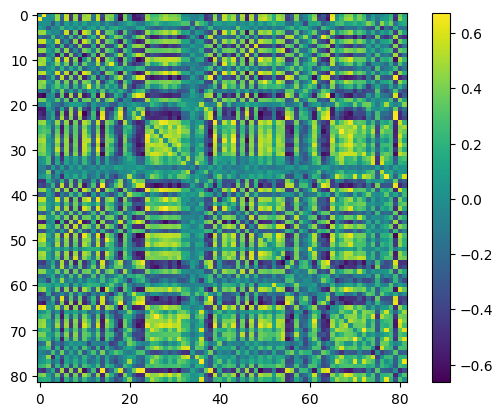

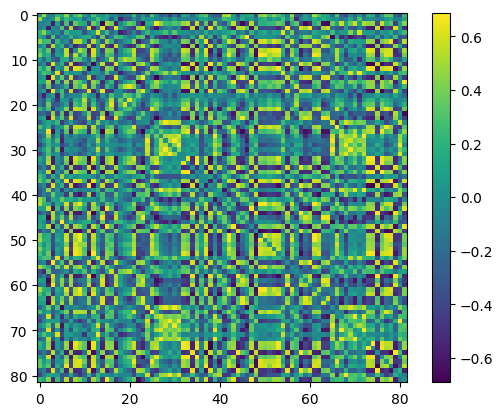

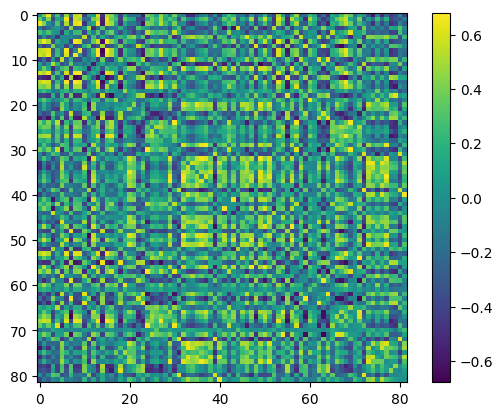

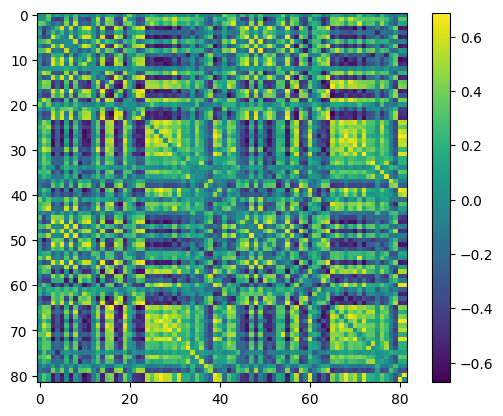

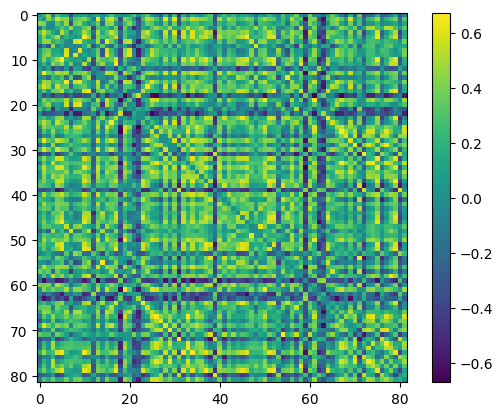

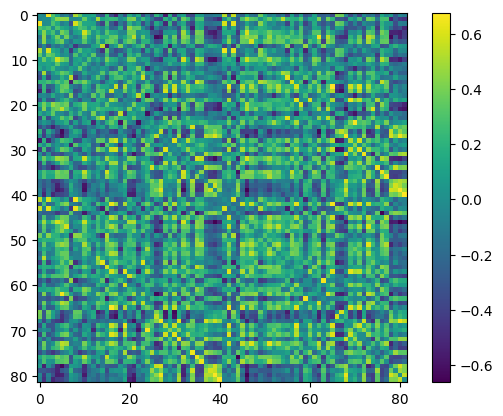

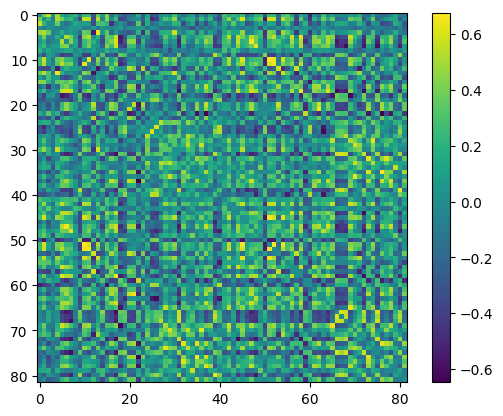

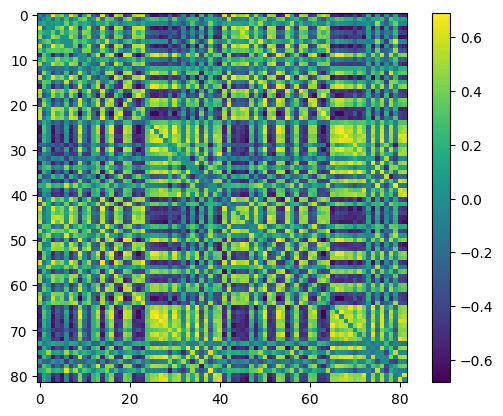

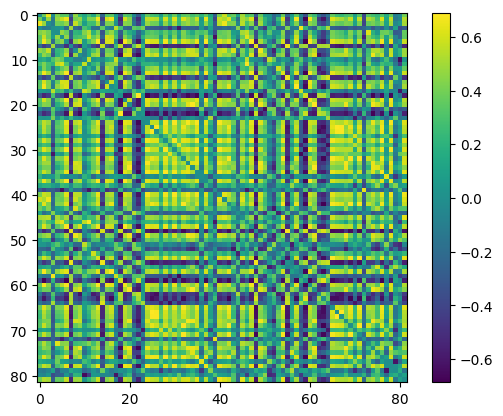

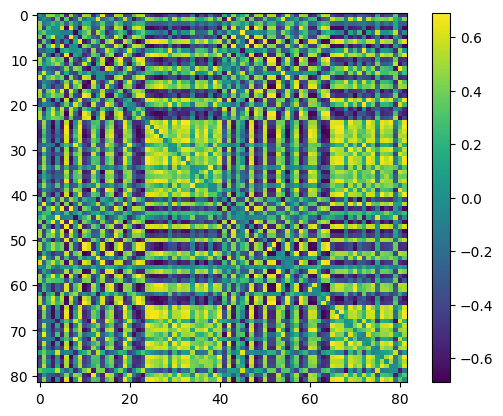

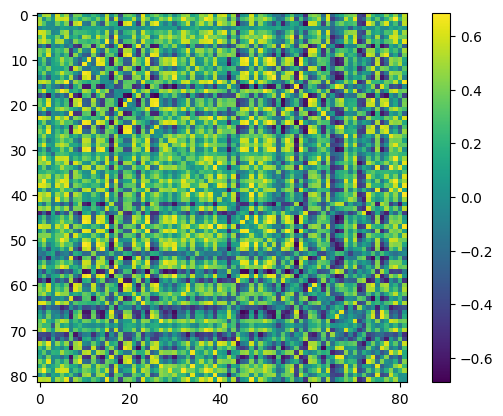

In [22]:
import matplotlib.animation as animation

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
for a in list(range(31)) :
    ims = []
    fig, ax = plt.subplots()
    for i in range(464):
        im = ax.imshow(dfc_all[a,i,:,:], animated=True)
        if i == 0:
            ax.imshow(dfc_all[a,i,:,:])  # show an initial one first
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    fig.colorbar(im, ax=ax)
    
    ani.save("/volatile/aurelien_stumpf_mascles/project/data/visuals/animation/awake/movie{}.mp4".format(a))
    print("Saved at /volatile/aurelien_stumpf_mascles/project/code/visuals/animation/movie{}.mp4".format(a))

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [11]:
l = np.zeros((464))
for i in range(464):
    l[i] = np.mean(np.abs(dfc[0,i,:,:]))
arg = np.argsort(l)

In [12]:
arg

array([ 50,  51, 275, 276, 274,  52,  49, 440, 273, 439, 277, 441, 134,
        53, 438, 135, 133, 442, 272, 178,  48, 179, 177, 278,  27,  54,
       443, 176,  26, 132,  28, 412, 413, 411,  25, 180, 437,  29, 175,
       410, 271, 414, 136, 444,  24,  55,  30, 279, 409, 174,  23, 445,
       131,  47, 415,  22,  17,  18,  16,  19,  15,  31, 446,  20, 181,
        21,  14,  56, 408, 270, 447,  13, 173, 342, 436,  57, 341,  32,
       280, 448, 416, 343,  58,  12,  59, 407, 137,  60, 172, 182, 269,
       340,  46,  33, 449, 130, 344,  61,  11, 291, 406, 281, 292, 290,
       417, 345, 435, 293, 450, 171, 192, 268, 294,  34, 295, 296, 289,
        62, 297, 193, 191, 339, 138, 391,  10, 346, 298, 390, 183, 405,
        45, 288, 282, 190, 299, 347, 267, 194, 170, 451, 142, 141, 392,
       139,  35, 389,  63, 140, 143, 418, 348, 300, 287,   9, 129, 189,
       283, 338, 404, 266, 349, 144, 434, 184, 207, 169, 208, 286, 350,
       284, 301, 285, 195, 188, 351, 145, 265,  44, 452,  36, 16

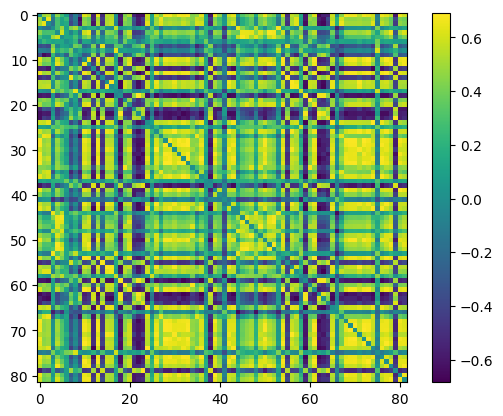

In [252]:
fig, ax = plt.subplots()
im = ax.imshow(dfc[0,0,:,:])
fig.colorbar(im,ax=ax)
plt.show()

## Implémentation de CEBRA sur le dataset awake avec la metric structure et les labels

In [7]:
dfc_train_awake = dfc[(meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])) & (meta["condition"] == "awake")].reshape(-1,n_wins,82,82)

In [8]:
fc_train = torch.from_numpy(dfc_train_awake[0:8,:,:,:].reshape((8,464,1,82,82)))
distance = np.load("./DistanceMatrices/awake/distance_matrix_8_sessions_structure.npy")

(array([1.03500e+04, 3.69600e+03, 3.11200e+03, 3.00600e+03, 2.62200e+03,
        2.15000e+03, 2.08000e+03, 2.13200e+03, 1.94000e+03, 1.84200e+03,
        1.84800e+03, 1.74600e+03, 1.64800e+03, 1.73400e+03, 1.69400e+03,
        1.58600e+03, 1.72400e+03, 1.81400e+03, 1.67800e+03, 1.73800e+03,
        1.97400e+03, 2.02600e+03, 2.03600e+03, 2.28200e+03, 2.51800e+03,
        2.66600e+03, 3.18800e+03, 3.69400e+03, 4.14200e+03, 4.53400e+03,
        5.09600e+03, 6.10600e+03, 7.54600e+03, 8.96200e+03, 1.03380e+04,
        1.15140e+04, 1.37220e+04, 1.66440e+04, 1.95860e+04, 2.25680e+04,
        2.54620e+04, 2.83980e+04, 3.29360e+04, 3.81920e+04, 4.29220e+04,
        4.89340e+04, 5.41840e+04, 6.13880e+04, 6.78600e+04, 7.44240e+04,
        8.24680e+04, 9.00060e+04, 9.90520e+04, 1.07978e+05, 1.19026e+05,
        1.29728e+05, 1.43754e+05, 1.59870e+05, 1.72600e+05, 1.86066e+05,
        2.02698e+05, 2.19928e+05, 2.37266e+05, 2.55708e+05, 2.73400e+05,
        2.90618e+05, 3.11032e+05, 3.29822e+05, 3.46

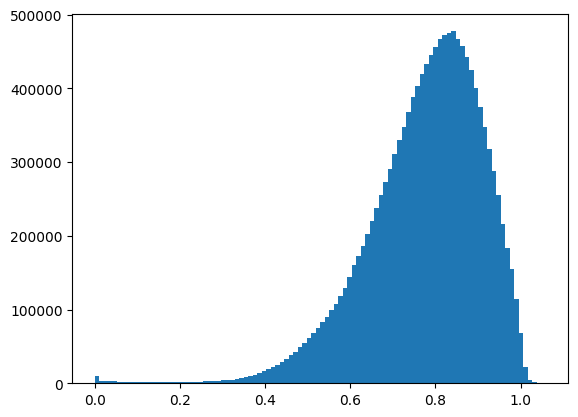

In [9]:
dist = distance.flatten()
plt.hist(dist,bins=100)

In [10]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        num_output,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

Question : comment choisir le matrix_delta ?
Si le matrix_delta est très petit, l'embedding ne formera pas de clusters de points distincts mais plutôt des formes continues (pourquoi??)
Si le matrix_delta est trop grand, l'embedding rapprochera trop de points différents et ne formera donc pas de clusters de points. 

In [11]:
fc_train = torch.squeeze(fc_train,dim=2)
fc_train_vector = torch.from_numpy(package.preprocessing.flatten_higher_triangular(fc_train))
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 3000,  distance = torch.from_numpy(distance), time_delta = 0, matrix_delta = 0.35)

In [12]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [19]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.1836, Train accuracy 0.00%
Epoch 100
Train loss 7.1833, Train accuracy 0.00%
Epoch 200
Train loss 7.1845, Train accuracy 0.00%
Epoch 300
Train loss 7.1800, Train accuracy 0.00%
Epoch 400
Train loss 7.1818, Train accuracy 0.00%
Epoch 500
Train loss 7.1808, Train accuracy 0.00%
Epoch 600
Train loss 7.1820, Train accuracy 0.00%
Epoch 700
Train loss 7.1800, Train accuracy 0.00%
Epoch 800
Train loss 7.1805, Train accuracy 0.00%
Epoch 900
Train loss 7.1802, Train accuracy 0.00%


(-1.0805650082902296,
 1.0531557287337463,
 -1.099969771843923,
 1.099647597463247)

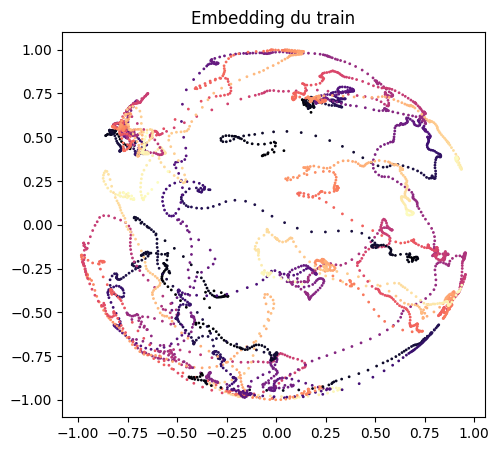

In [21]:
a,b,c = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,c)
fc_emb = _compute_emissions_single(cebra_fc, data)
r = R.from_rotvec([1.5*np.pi/2, 0*np.pi/2, -1.6*np.pi/2])
fc_emb = r.apply(fc_emb)
fc_emb = fc_emb.reshape((a,b,3))
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
colors = ["black",'red','green','blue','purple']
for i in [0,1,2,3,4,5,6,7]:
    ax1.scatter(fc_emb[i,:,0], fc_emb[i,:,2], cmap = "magma", c = np.arange(464), s=1)
#ax1.xticks() 
ax1.axis('on')

(-1.1, 1.1, -1.0998615404412626, 1.0998615404412626)

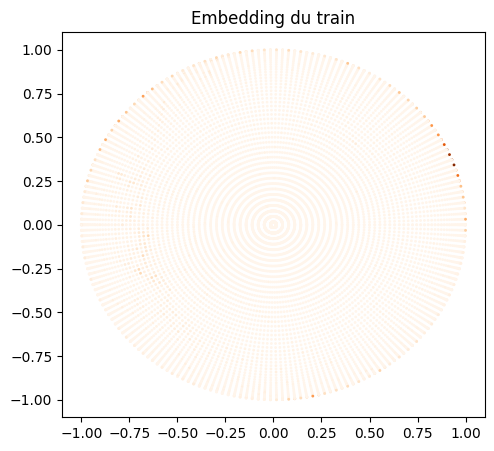

In [48]:
a,b = np.meshgrid(np.linspace(0,2*np.pi,100),-np.linspace(0,np.pi,100))
x = (np.cos(a)*np.cos(b)).reshape(-1,1)
y = (np.sin(a)*np.cos(b)).reshape(-1,1)
z = np.sin(b).reshape(-1,1)
sphere = np.concatenate((x,y,z),axis = 1)

def create_heat_sphere(fc_emb,sphere):
    heatmap = np.zeros(len(sphere))
    for idx in range(len(fc_emb)):
        accu_id = np.argmin(np.linalg.norm(sphere - fc_emb[idx,:],axis=1))
        heatmap[accu_id] += 1
    return heatmap 

heatmap = create_heat_sphere(fc_emb.reshape(6*464,3),sphere)

fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title('Embedding du train')
ax1.scatter(sphere[:,0], sphere[:,1], cmap = "Oranges", c = heatmap, s=1)
#ax1.xticks() 
ax1.axis('on')


## KMeans 

Text(0.5, 1.0, 'Elbow curve')

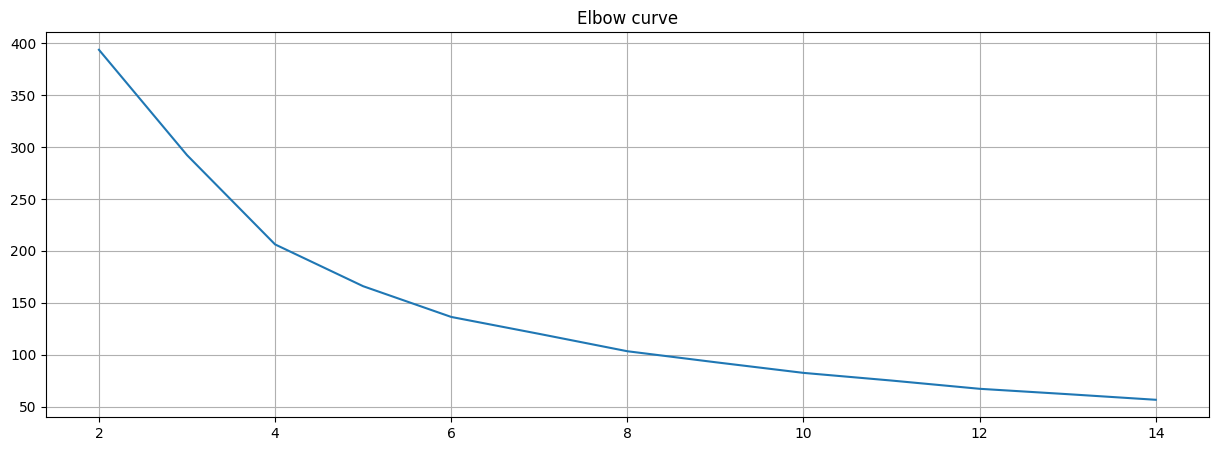

In [75]:
X = fc_emb.reshape(7*464,3)
distorsions = []
for k in range(2, 15):
    accu = 0
    for l in range(10):
        kmeans = KMeans(n_clusters=k,n_init="auto")
        kmeans.fit(X)
        accu += kmeans.inertia_
    distorsions.append(accu/10)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 15), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [76]:
kmeans = KMeans(n_clusters=6,n_init="auto")
Y = np.argmin(kmeans.fit_transform(X),axis=1)

(-1.099170509344455,
 1.0989480862774683,
 -1.0991873976696325,
 1.0994812800159248)

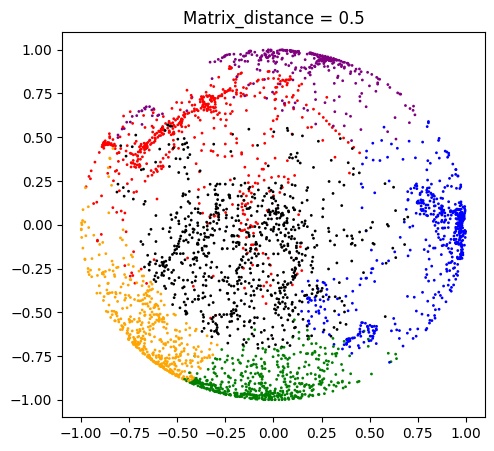

In [77]:
data_print = fc_emb.reshape(7*464,3)
r = R.from_rotvec([0, 0, 0.2*np.pi/2])
data_print = r.apply(data_print)
labels_print = Y
fig = plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.set_title("Matrix_distance = 0.5")
colors = ["black",'red','green','blue','purple',"orange"]
ax1.scatter(data_print[:,0], data_print[:,2], cmap = matplotlib.colors.ListedColormap(colors), c = labels_print, s=1)
ax1.axis('on')

In [332]:
fc_train_vector.shape

torch.Size([6, 464, 3321])

In [78]:
list_label = Y
data_mat = fc_train.reshape(7*464,82,82).detach().numpy()
mean_states = np.array([np.mean(data_mat[Y == i],axis=0) for i in range(6)])
accu = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(mean_states.reshape(1,6,82,82)))).type(torch.float32)
states_positions = _compute_emissions_single(cebra_fc, accu)

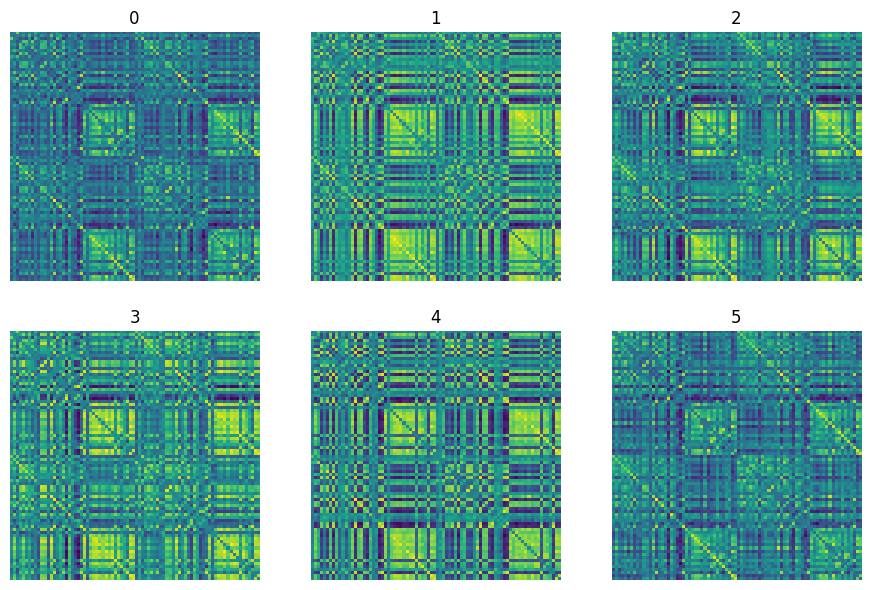

In [79]:
display(mean_states,np.arange(6))

In [115]:
np.save(file = "./BrainStates/awake/mean_states.npy",arr = mean_states)

: 

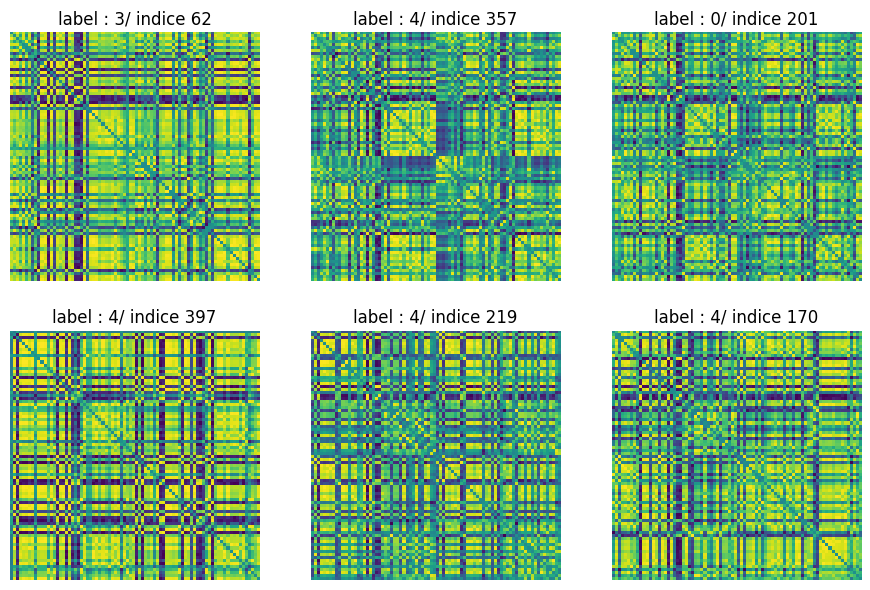

In [103]:
l = np.random.randint(0,464,6)
labels = list_label.reshape(5,464)
li_mat = [dfc_train_awake[3,k,:,:] for k in l]
li_titles = ["label : " + str(labels[3,k]) + "/ indice {}".format(k) for k in l]
display(li_mat,li_titles)

## Etude des transitions

(0.0, 6.0)

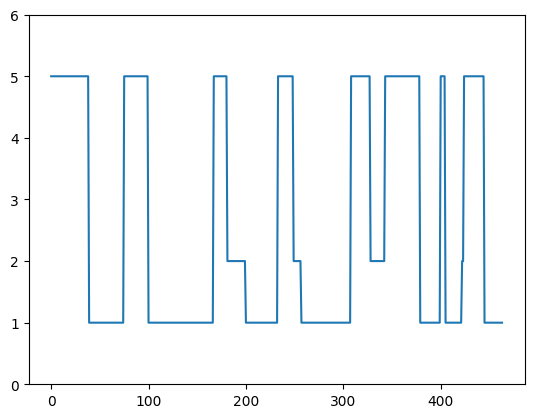

In [114]:
labels = list_label
session = fc_emb[4,:]
labels_by_session = labels.reshape(5,464)
plt.plot(labels_by_session[4,:])
plt.ylim(0,6)

In [287]:
def trunc(a, x):
    int1 = int(a * (10**x))/(10**x)
    return float(int1)

In [549]:
transition_list = []
for a in range(8):
    for i in range(463):
        session = fc_emb[a,:,:]
        labels = np.argmin(kmeans.transform(session),axis=1) 
        transition = (labels[i],labels[i+1])
        if not(transition in transition_list) and transition[0] != transition[1]:
            transition_list.append(transition)

transition_count = {key: 0 for key in transition_list}
for a in range(8):
    for i in range(463):
        session = fc_emb[a,:,:]
        labels = np.argmin(kmeans.transform(session),axis=1) 
        transition = (labels[i],labels[i+1])
        if transition[0] != transition[1]:
            transition_count[transition] += 1

dist = {key: 0 for key in transition_list}
mean_states_absolute = torch.from_numpy(np.abs(mean_states).reshape(6,1,82,82))
for edge in transition_list:
    dist[edge] = trunc(package.preprocessing.structure(mean_states_absolute[edge[0],:,:,:],mean_states_absolute[edge[1],:,:,:],val_range = 1).item(),2)


In [450]:
dist

{(2, 6): 0.37,
 (6, 2): 0.37,
 (2, 1): 0.44,
 (1, 2): 0.44,
 (6, 4): 0.45,
 (4, 5): 0.42,
 (5, 1): 0.25,
 (1, 5): 0.25,
 (5, 4): 0.42,
 (1, 6): 0.43,
 (6, 1): 0.43,
 (4, 3): 0.54,
 (3, 6): 0.46,
 (4, 1): 0.47,
 (4, 6): 0.45,
 (5, 0): 0.31,
 (0, 5): 0.31,
 (0, 3): 0.4,
 (3, 4): 0.54,
 (3, 0): 0.4,
 (4, 0): 0.55,
 (0, 4): 0.55,
 (0, 2): 0.43,
 (2, 3): 0.25}

In [451]:
transition_count

{(2, 6): 13,
 (6, 2): 9,
 (2, 1): 5,
 (1, 2): 7,
 (6, 4): 4,
 (4, 5): 9,
 (5, 1): 5,
 (1, 5): 5,
 (5, 4): 9,
 (1, 6): 8,
 (6, 1): 9,
 (4, 3): 7,
 (3, 6): 1,
 (4, 1): 1,
 (4, 6): 2,
 (5, 0): 1,
 (0, 5): 1,
 (0, 3): 10,
 (3, 4): 6,
 (3, 0): 11,
 (4, 0): 9,
 (0, 4): 9,
 (0, 2): 1,
 (2, 3): 1}

In [452]:
edges

[(0, 6),
 (6, 3),
 (3, 6),
 (6, 2),
 (2, 6),
 (2, 5),
 (5, 2),
 (2, 0),
 (0, 5),
 (5, 0),
 (3, 4),
 (4, 0),
 (5, 7),
 (7, 5),
 (0, 3),
 (3, 1),
 (1, 3),
 (0, 4),
 (1, 7),
 (4, 5),
 (7, 4),
 (4, 7),
 (7, 1)]

In [321]:
d

{0: array([[ 1., -1.,  1.]], dtype=float32),
 1: array([[-1.,  1., -1.]], dtype=float32),
 2: array([[-1., -1., -1.]], dtype=float32),
 3: array([[-1.,  1.,  1.]], dtype=float32),
 4: array([[1., 1., 1.]], dtype=float32),
 5: array([[ 1., -1., -1.]], dtype=float32),
 6: array([[-1., -1.,  1.]], dtype=float32),
 7: array([[ 1.,  1., -1.]], dtype=float32)}

In [551]:
transition_count

{(3, 5): 13,
 (5, 3): 9,
 (3, 0): 3,
 (0, 3): 5,
 (5, 4): 5,
 (4, 0): 4,
 (0, 4): 3,
 (0, 5): 11,
 (5, 0): 11,
 (4, 5): 4,
 (1, 3): 1,
 (3, 1): 1,
 (1, 5): 2,
 (5, 1): 2,
 (1, 4): 2,
 (4, 1): 2,
 (2, 4): 18,
 (4, 2): 18,
 (2, 3): 2,
 (3, 2): 2}

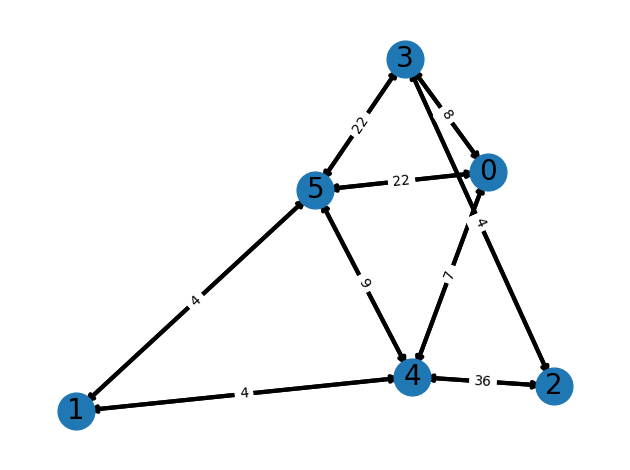

In [554]:
G = nx.DiGraph()

transitions = [edge for edge in transition_list if transition_count[edge] > 1]
edges = transitions

for edge in edges : 
    G.add_edge(edge[0], edge[1], weight=transition_count[edge]+transition_count[(edge[1],edge[0])])

pos = nx.spring_layout(G, seed=7)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transitions, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


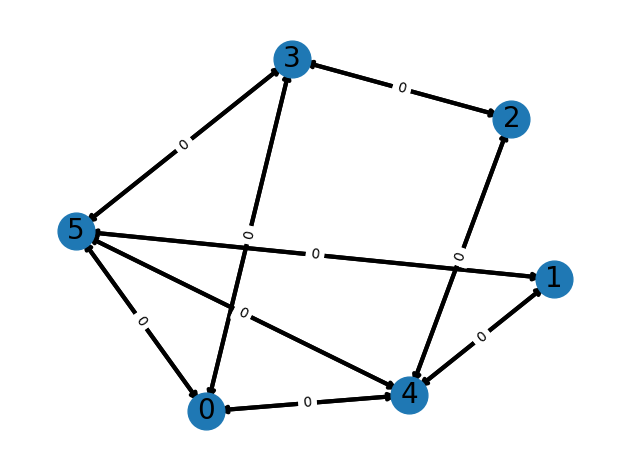

In [548]:
G = nx.DiGraph()

transitions = [edge for edge in transition_list if transition_count[edge] > 1]
edges = transitions

for edge in edges : 
    G.add_edge(edge[0], edge[1], weight=(dist[edge]))

pos = nx.spring_layout(G, seed = 1)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=transitions, width=3, arrowstyle="->",arrowsize=10)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

{(0, 6): Text(0.1610747396911919, 0.22825355693473542, '7'),
 (0, 5): Text(0.42863127007557167, -0.0994602840073811, '4'),
 (0, 3): Text(-0.17812697028754318, 0.3653122352450129, '4'),
 (0, 4): Text(0.27967970640901363, 0.49404771232443095, '3'),
 (6, 3): Text(-0.3744502438531275, 0.2732819794288015, '11'),
 (6, 2): Text(0.39725135142907136, 0.021950917686167255, '10'),
 (3, 6): Text(-0.3744502438531275, 0.2732819794288015, '5'),
 (3, 4): Text(-0.2558452771353057, 0.539076134818497, '3'),
 (3, 1): Text(-0.8568259769159312, 0.016653485332681434, '6'),
 (2, 6): Text(0.39725135142907136, 0.021950917686167255, '10'),
 (2, 5): Text(0.6648078818134511, -0.3057629232559493, '2'),
 (2, 0): Text(0.5935746249946556, 0.1139811735023786, '2'),
 (5, 2): Text(0.6648078818134511, -0.3057629232559493, '3'),
 (5, 0): Text(0.42863127007557167, -0.0994602840073811, '7'),
 (5, 7): Text(0.17989491907784685, -0.5326521153432793, '7'),
 (4, 0): Text(0.27967970640901363, 0.49404771232443095, '5'),
 (4, 5): Te

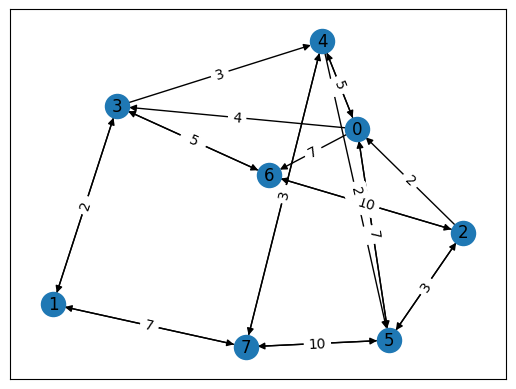

In [356]:
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

## OPTICS ON NON TRANSFORMED DATA

In [7]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

distance = np.load("./DistanceMatrices/awake/distance_matrix_8_sessions_structure.npy")

def STRUCTURE2(idx,idy):
        return distance[idx[0],idx[1],idy[0],idy[1]]

metric = STRUCTURE2

In [8]:
dfc_train_awake = dfc[(meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])) & (meta["condition"] == "awake")].reshape(-1,n_wins,82,82)
fc_train = dfc_train_awake[0:8,:,:,:].reshape((8*464,1,82,82))
X = distance.reshape((8*464,8*464))

For n_clusters = 35 The average silhouette_score is : -0.01939739364425623


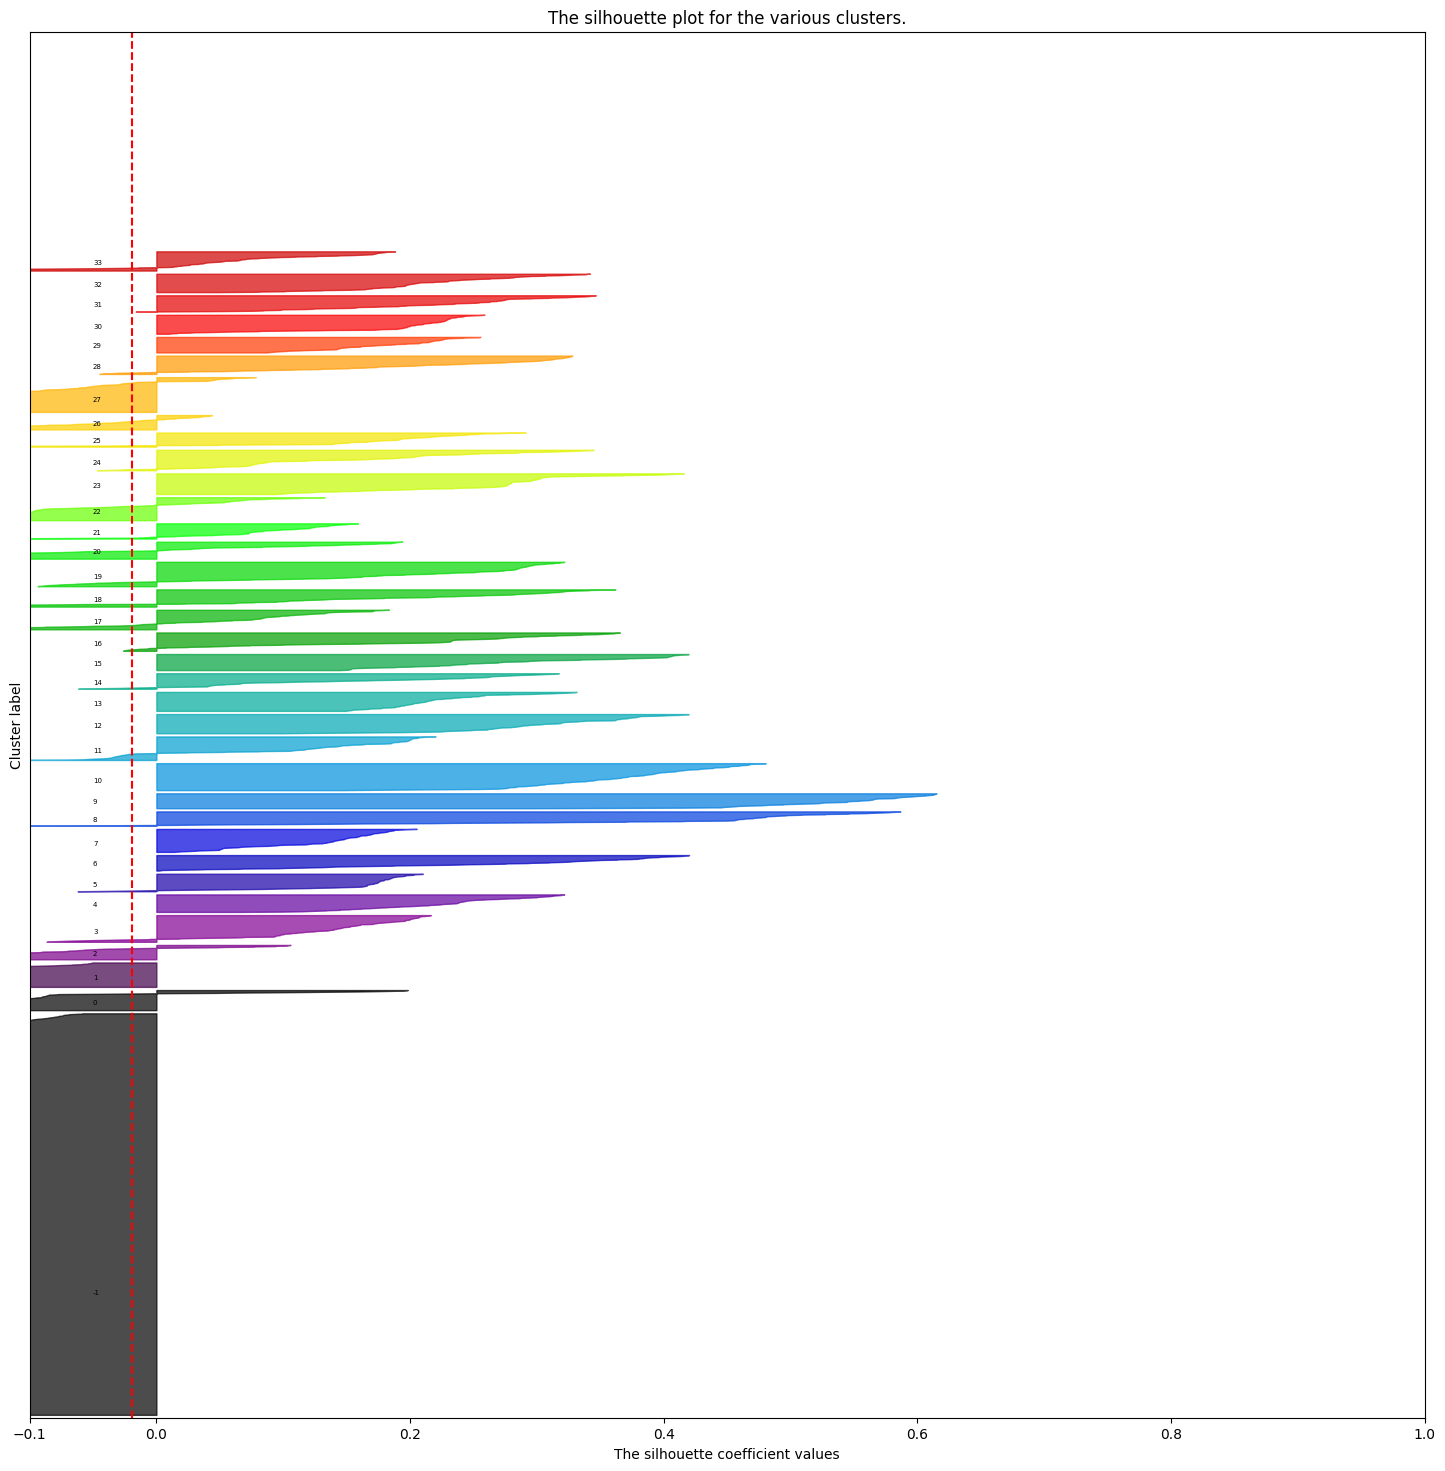

In [9]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
#clustering = DBSCAN(eps=0.2, min_samples=13, metric="precomputed").fit(X)
clustering = OPTICS(min_samples=5, min_cluster_size = 50, metric="precomputed").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels, metric = "precomputed")
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels, metric = "precomputed")

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

(array([1399.,   71.,   86.,   51.,   94.,   62.,   62.,   55.,   81.,
          51.,   53.,   95.,   83.,   68.,   67.,   55.,   57.,   65.,
          69.,   61.,   86.,   60.,   54.,   81.,   73.,   72.,   50.,
          51.,  122.,   65.,   55.,   67.,   58.,   65.,   68.]),
 array([-1.00000000e+00, -2.85714286e-02,  9.42857143e-01,  1.91428571e+00,
         2.88571429e+00,  3.85714286e+00,  4.82857143e+00,  5.80000000e+00,
         6.77142857e+00,  7.74285714e+00,  8.71428571e+00,  9.68571429e+00,
         1.06571429e+01,  1.16285714e+01,  1.26000000e+01,  1.35714286e+01,
         1.45428571e+01,  1.55142857e+01,  1.64857143e+01,  1.74571429e+01,
         1.84285714e+01,  1.94000000e+01,  2.03714286e+01,  2.13428571e+01,
         2.23142857e+01,  2.32857143e+01,  2.42571429e+01,  2.52285714e+01,
         2.62000000e+01,  2.71714286e+01,  2.81428571e+01,  2.91142857e+01,
         3.00857143e+01,  3.10571429e+01,  3.20285714e+01,  3.30000000e+01]),
 <BarContainer object of 35 artists

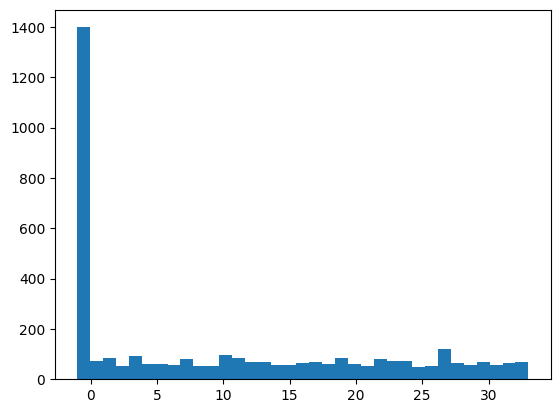

In [10]:
plt.hist(clustering.labels_,bins = len(np.unique(clustering.labels_)))

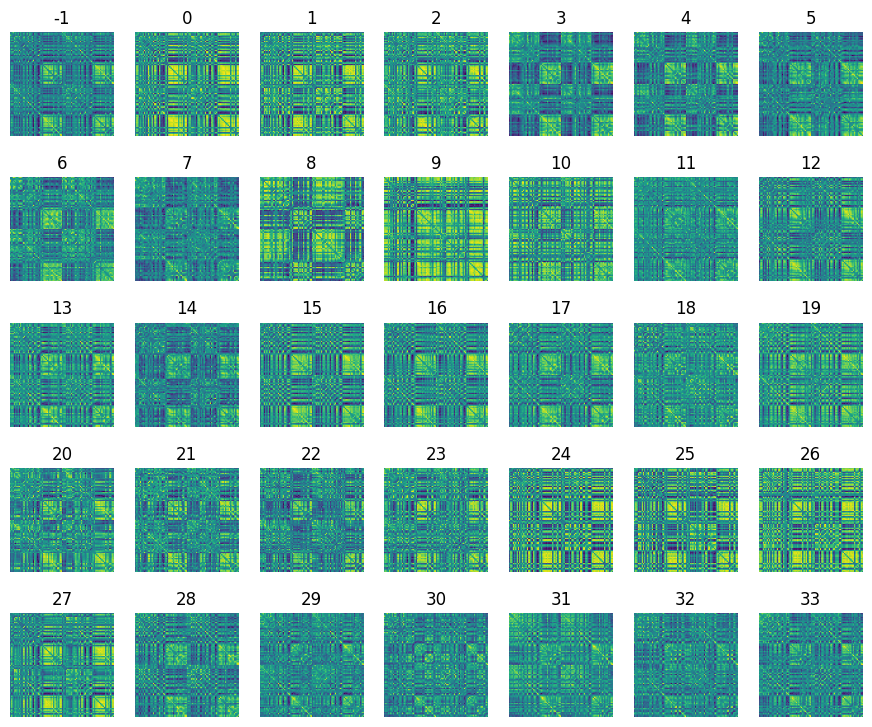

In [11]:
list_label = clustering.labels_
data_mat = fc_train.reshape(8*464,82,82)
mean_states = np.array([np.mean(data_mat[list_label == i],axis=0) for i in np.unique(clustering.labels_)])
accu = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(mean_states.reshape(1,len(np.unique(clustering.labels_)),82,82)))).type(torch.float32)
display(mean_states,np.unique(clustering.labels_))

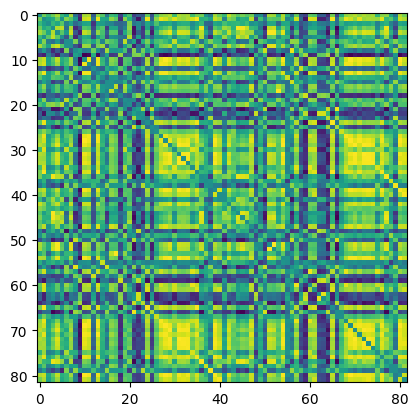

In [128]:
plt.imshow(mean_states[2])

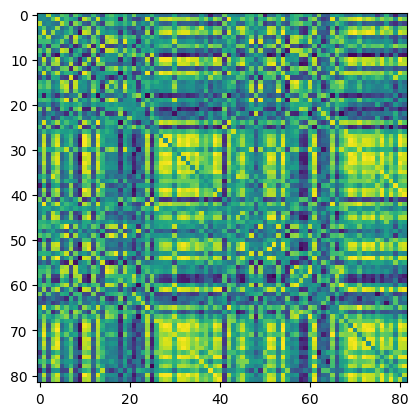

In [124]:
plt.imshow(mean_states[3])

In [12]:
mat = np.zeros((len(mean_states),len(mean_states)))
states = torch.from_numpy(mean_states)
for i in range(len(mean_states)):
    for j in range(i+1, len(states)):
        accu = STRUCTURE(states[i],states[j]).item()
        mat[i,j] = accu
        mat[j,i] = accu

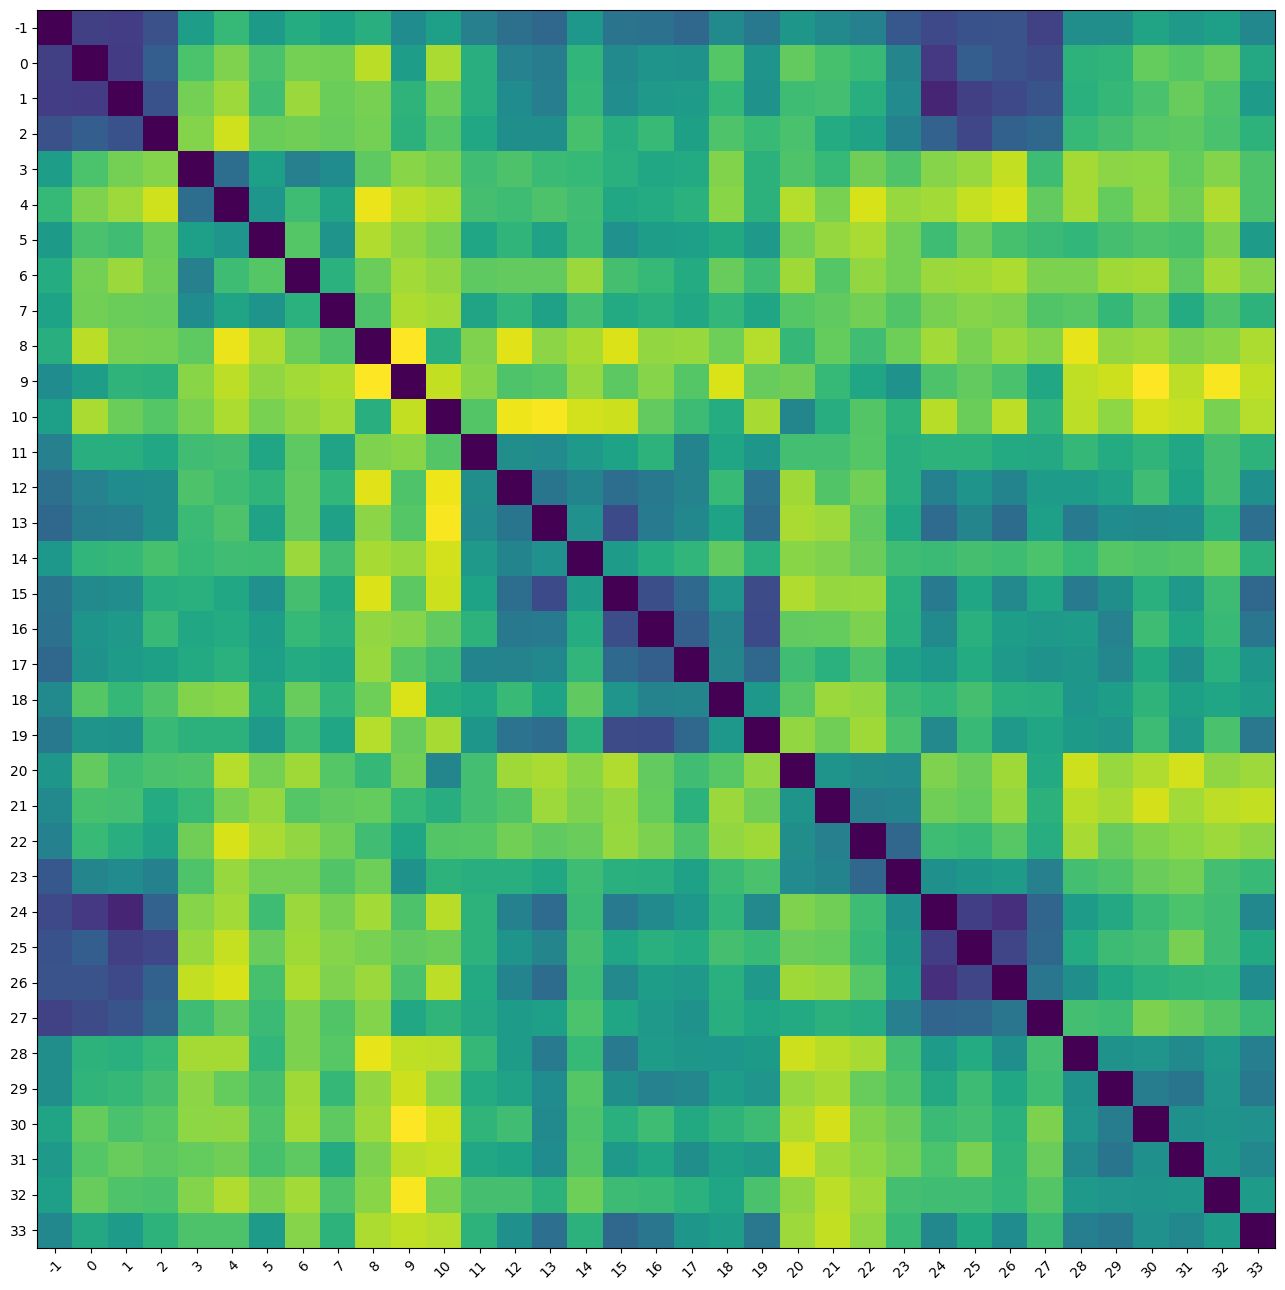

In [13]:
fig, ax = plt.subplots(figsize = (13,13))
im = ax.imshow(mat,extent = (-1.5, len(mat) - 1.5, len(mat) - 1.5, -1.5))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(-1,len(mat)-1), labels=np.arange(-1,len(mat)-1))
ax.set_yticks(np.arange(-1,len(mat)-1), labels=np.arange(-1,len(mat)-1))

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

"""
# Loop over data dimensions and create text annotations.
for i in range(-1,len(mat)-1):
    for j in range(-1,len(mat)-1):
        text = ax.text(j, i, np.around(mat[i+1, j+1],decimals=1),
                       ha="center", va="center", color="w")
"""

fig.tight_layout()
plt.show()

In [14]:
dict_categories_to_labels = {}
cluster_num = 1
for i in range(1,len(mat)):
    flag = False
    for key,li in dict_categories_to_labels.items():
        for idx in li :
            if mat[i,idx+1] < 0.35 :
                dict_categories_to_labels[key].append(i-1)
                flag = True
                break
        if flag : 
            break
    if not flag : 
        dict_categories_to_labels[cluster_num] = [i-1]
        cluster_num += 1

In [15]:
dict_categories_to_labels

{1: [0, 1, 2, 24, 25, 26, 27],
 2: [3, 4],
 3: [5],
 4: [6],
 5: [7],
 6: [8],
 7: [9],
 8: [10],
 9: [11],
 10: [12, 13, 15, 16, 17, 19, 33],
 11: [14],
 12: [18],
 13: [20],
 14: [21],
 15: [22, 23],
 16: [28],
 17: [29, 31],
 18: [30],
 19: [32]}

In [20]:
dict_labels_to_categories = {}
for k,li in dict_categories_to_labels.items():
    for elem in li:
        dict_labels_to_categories[elem] = k
dict_labels_to_categories[-1] = -1

In [21]:
dict_labels_to_categories

{0: 1,
 1: 1,
 2: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 3: 2,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 10,
 15: 10,
 16: 10,
 17: 10,
 19: 10,
 33: 10,
 14: 11,
 18: 12,
 20: 13,
 21: 14,
 22: 15,
 23: 15,
 28: 16,
 29: 17,
 31: 17,
 30: 18,
 32: 19,
 -1: -1}

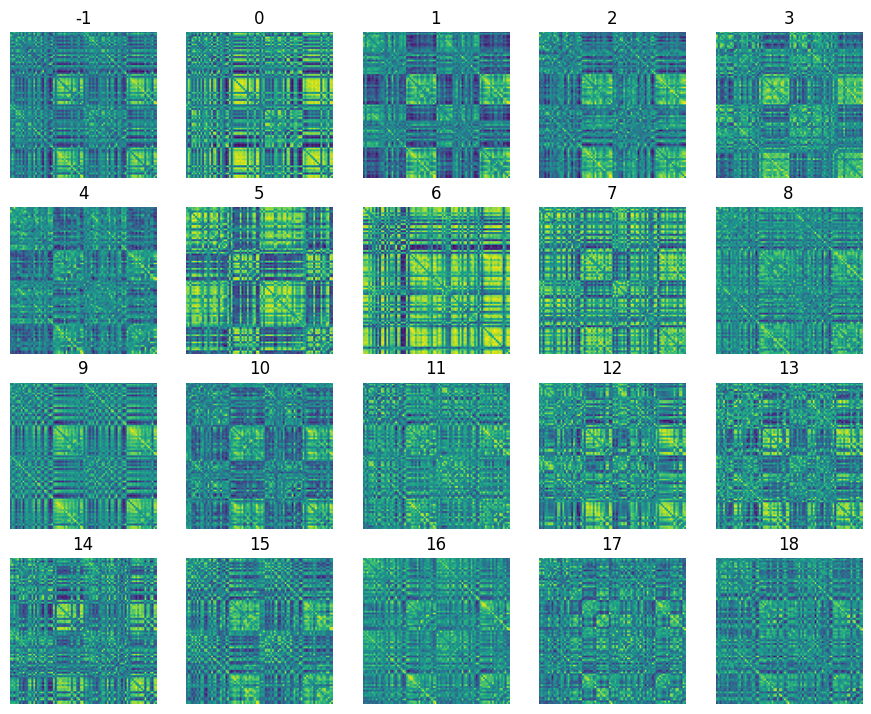

In [24]:
list_label = np.array([dict_labels_to_categories[x] for x in cluster_labels])
data_mat = fc_train.reshape(8*464,82,82)
mean_states = np.array([np.mean(data_mat[list_label == i],axis=0) for i in np.sort(np.unique(list_label))])
accu = torch.from_numpy(package.preprocessing.flatten_higher_triangular(torch.from_numpy(mean_states.reshape(1,len(np.unique(list_label)),82,82)))).type(torch.float32)
display(mean_states,np.unique(clustering.labels_))

In [25]:
np.save(file = "./BrainStates/awake/mean_states.npy",arr = mean_states)